In [1]:
# Group Number: 03
# Group Members: Kurt Kilian Eifler, Moritz Ladwig, Simon Grünewald

import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import numpy.matlib as ml
import imageio
import skimage
import scipy
import time

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)

# Exercise 2

## 2.1 Sampling

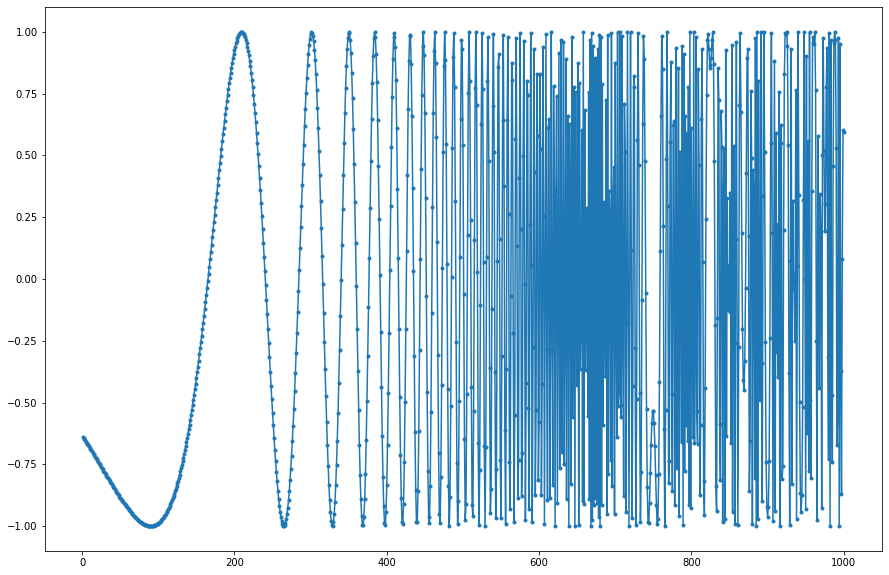

In [2]:
# Plot a frequency sweep from 0.001Hz to 10Hz per Pixel width

# Init some x values
x = np.arange(1,1001)

# Evaluate our sweep function at position 'x'
def evalSweep(x):
     return np.sin( -np.pi * np.power( 2, 1-(150-x) / 250 ) * np.power( 5, (-150+x)/250 ) / np.log(10) )
     
# Calculate and plot y values for sine sweep
y = evalSweep(x)
plt.plot(x,y,".-");


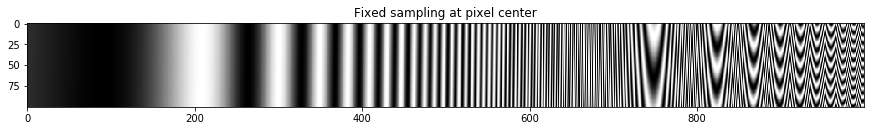

In [21]:
# Next create pattern as above as an image

# We simulate a camera with an indefinitively small fill-factor and therefore calculate the value for each pixel by sampling the frequency sweep only in the middle of the pixel.
imgHeight = 100
imgWidth = 1000

xImg = np.reshape( np.arange(0,imgWidth), (1,imgWidth) ) + np.reshape( np.linspace(0,1,imgHeight),(imgHeight,1) )


# Calculate y values for sine sweep. Use evalSweep and remember to corectly normalize the sine
yImg = (evalSweep(xImg + 0.5 ) + 1 ) / 2

plt.title('Fixed sampling at pixel center')
plt.imshow(yImg, cmap='gray', vmin=0.0, vmax=1.0);

# Where do the weird pattern right of pixel 500 come from?
# Die feinen Frequenzen, ab Pixel 500, können aufgrund des zu geringen Sampings 
# nicht dargestellt werden können. (vgl. Moiree Effekt)

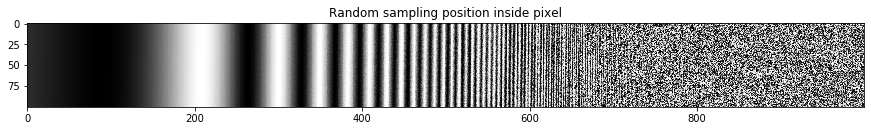

In [24]:
# Now we create the same 2D image but sample at a random position inside each pixel
xRandImg = xImg +  np.random.rand(imgHeight,imgWidth)
yRandImg = (evalSweep(xRandImg) + 1 ) / 2
plt.title('Random sampling position inside pixel')
plt.imshow( yRandImg, cmap='gray', vmin=0.0, vmax=1.0)

# What happened to the weird pattern in the high frequencies?
# Die "Korngröße" des Rauschens wird ab Pixel 500 gröber als die immer feiner werdenden Frequenzen.
# Ab Pixel 800 lässt sich dann nur noch das Rauschen erkennen.
#

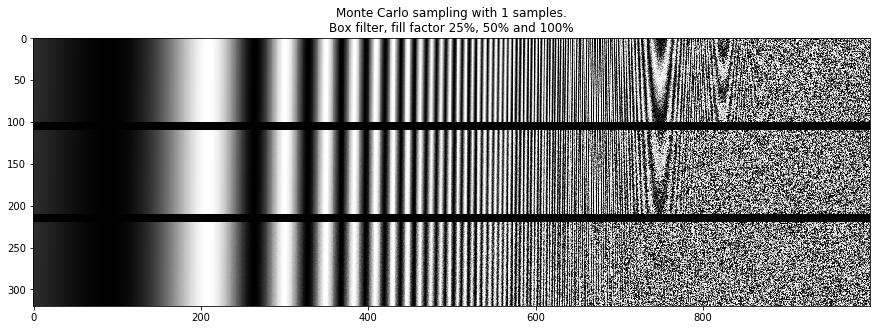

Calculating 1 samples took 1.8558578491210938 seconds


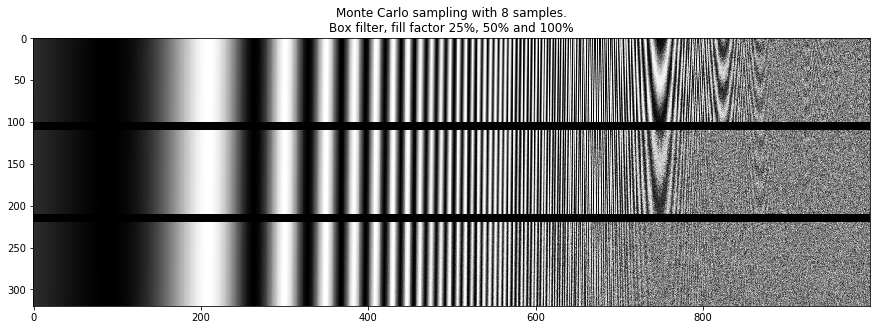

Calculating 8 samples took 2.8242616653442383 seconds


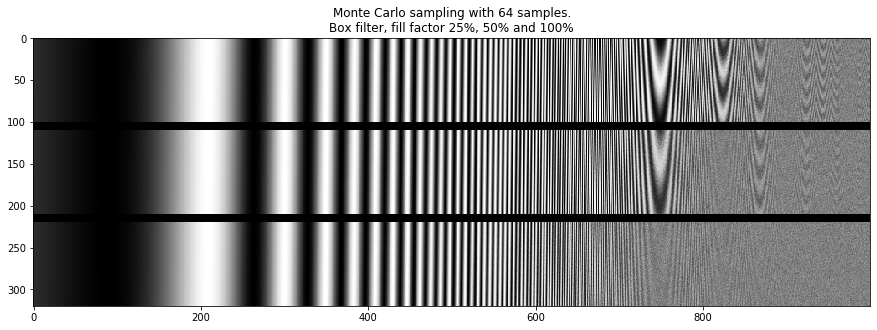

Calculating 64 samples took 8.6366868019104 seconds


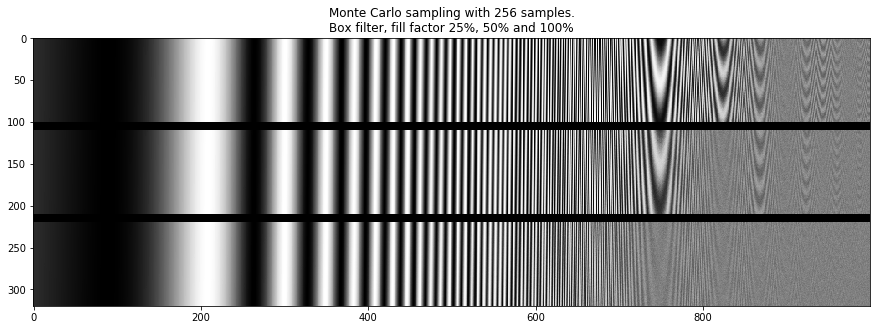

Calculating 256 samples took 32.1202290058136 seconds


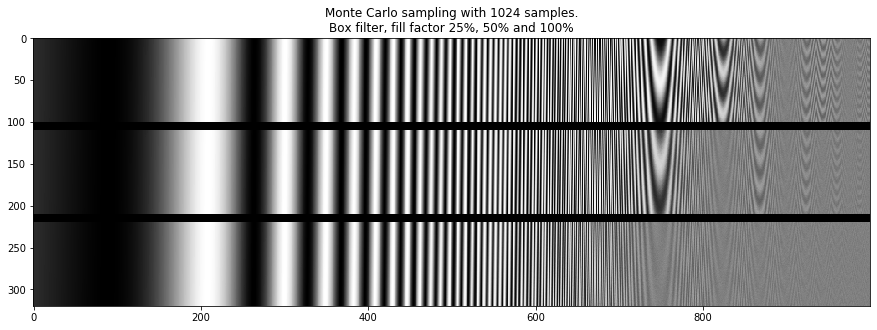

Calculating 1024 samples took 190.61001992225647 seconds


In [35]:
# Now let's sample the full pixelsize via monte carlo sampling (sample the value for each pixel at a random position inside the pixel)
# Put the number of samples in the third dimension (axis=2)
# Then calculate the mean of all samples.
# Simulate a fill factor of 50% and 25% by only sampling the respective area per pixel. The fill factor describes the area of the pixel that is sensitive to light and not covered by metal layers.

# Add a third dimension
xImg = np.reshape( xImg, (imgHeight,imgWidth,1))

for nSamples in [1, 8, 64, 256, 1024]: # Comment out 256 and 1024 for debugging. Add 2048, 4096 or 8192 if your computer has enough RAM and you want noise-free images (-:
    start=time.time()

    # Fill factor 25%
    xRandImg = xImg +    np.random.rand(imgHeight,imgWidth,nSamples) /4 # nur ein Viertel der Werte
       # yRandImgFF25 = (evalSweep(np.mean( xRandImg, axis=2)) + 1 ) / 2
    # Verkettung in falscher Reihenfolge: erst alle Farbwerte berechnen, dann Durchschnitt 
    # und nicht andersherum. nSamples auch noch einbinden. 
    # (Berechnung ging erstaunlich schnell & keine Unterschiede zwischen nSample Versionen)
    yRandImgFF25 = np.mean(((evalSweep(xRandImg) + 1 ) / 2), axis=2)          

    # Fill factor 50%
    xRandImg = xImg +    np.random.rand(imgHeight,imgWidth,nSamples) /2 # nur die Hälfte der Werte
    yRandImgFF50 = np.mean(((evalSweep(xRandImg) + 1 ) / 2), axis=2)   

    # Fill factor 100%
    xRandImg = xImg +    np.random.rand(imgHeight,imgWidth,nSamples) /1 # alle Werte
    yRandImgFF100 = np.mean(((evalSweep(xRandImg) + 1 ) / 2), axis=2) 

    # Show
    plt.title('Monte Carlo sampling with ' + str(nSamples) + ' samples.\nBox filter, fill factor 25%, 50% and 100%')
    plt.imshow(np.concatenate((yRandImgFF25, np.zeros((10,x.shape[0])), yRandImgFF50, np.zeros((10,x.shape[0])), yRandImgFF100) , axis=0), cmap='gray', vmin=0.0, vmax=1.0)
    plt.show()
    ende=time.time()
    print('Calculating ' + str(nSamples) + ' samples took ' + str(ende-start) + ' seconds')
    # Pause for a second before calculating the next image

# Can the weird patterns in the high frequencies be completely removed by a large fill factor?
# Nein. Bei sehr hoher Anzahl der Samples fällt auf, dass die Muster nur feiner werden, 
# aber nicht verschwinden.
#
# Bonus question for experts on the human visual system: Why are the small weird pattern only visible with 1024 samples and more?
# Banding Effekt?
#

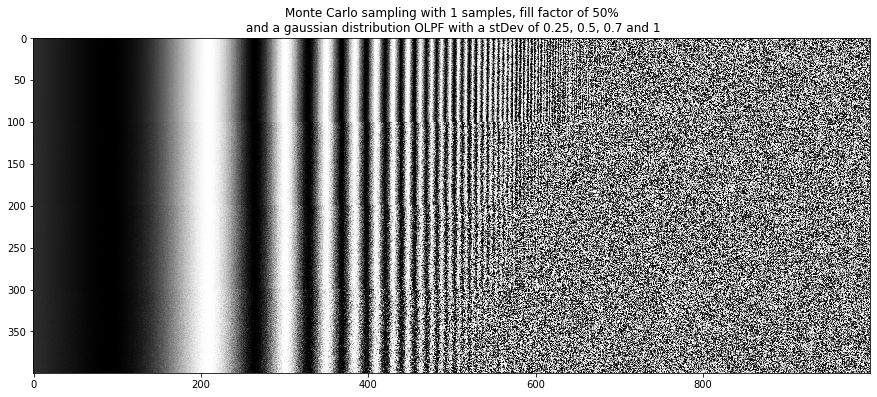

Calculating 1 samples took 2.2546145915985107 seconds


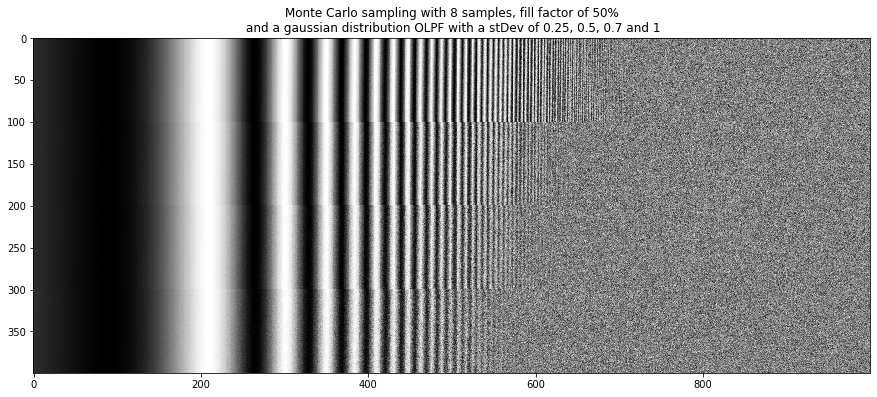

Calculating 8 samples took 3.6520767211914062 seconds


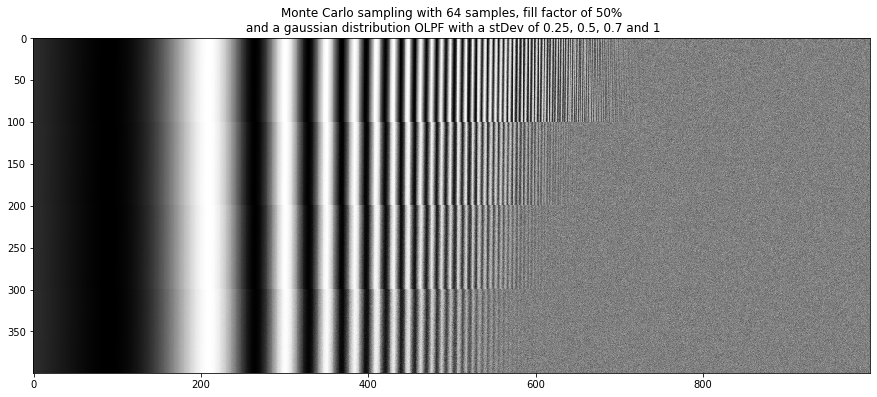

Calculating 64 samples took 14.75791621208191 seconds


In [45]:
# Now add a gaussian blur OLPF filter to a typical fill factor of 50% simulation by adding monte carlo sampling with a gaussian distribution ('randn').

for nSamples in [1, 8, 64, 256, 1024]: # Comment out 256 and 1024 for debugging. Add 2048, 4096 or 8192 if your computer has enough RAM and you want noise-free images (-:
    start = time.time()

    # OLPF filter with a StDev of 0.25 pixels
    # 1. Versuch: Rauschen im Nachhinein hinzufügen --> falsch
    '''xRandImg = xImg +    np.random.rand(imgHeight,imgWidth,nSamples) /2 # nur die Hälfte der Werte
    
    yRandImgStD025 =     np.mean(((evalSweep(xRandImg) + 1 ) / 2), axis=2) \
                         + np.random.rand(imgHeight,imgWidth) / 2 - 0.25 #Abweichung auf 0.5 
                         # Dividieren, dann um 0.25 nach "unten" verschieben
                         # um Abweichung in beide Richtungen zu erhalten'''
    # 2. Versuch: rand durch randn tauschen, nope: OPLF zuletzt addieren
    #                                                             nur die Hälfte der Werte: 50% Fill Factor
    xRandImg = xImg +    np.random.rand(imgHeight,imgWidth,nSamples) /2  \
                    +    np.random.randn(imgHeight,imgWidth,nSamples) / 2.0 - 0.25 
                    #OLPF addiert, /2 --> Abweichung von 0 bis 0.5; -0.25 --> Abweichung von -0.25 bis 0.25
    yRandImgStD025 =     np.mean(((evalSweep(xRandImg) + 1 ) / 2), axis=2) 
                         
    # OLPF filter with a StDev 0.5 pixels
    #                                                             nur die Hälfte der Werte: 50% Fill Factor
    xRandImg = xImg +    np.random.rand(imgHeight,imgWidth,nSamples) /2  \
                    +    np.random.randn(imgHeight,imgWidth,nSamples)  - 0.5 
                    #OLPF addiert
    yRandImgStD05 =     np.mean(((evalSweep(xRandImg) + 1 ) / 2), axis=2) 

    # OLPF filter with a StDev 0.7 pixels
    #                                                             nur die Hälfte der Werte: 50% Fill Factor
    xRandImg = xImg +    np.random.rand(imgHeight,imgWidth,nSamples) /2  \
                    +    np.random.randn(imgHeight,imgWidth,nSamples) * 1.4 - 0.7 
                    #OLPF addiert
    yRandImgStD07 =     np.mean(((evalSweep(xRandImg) + 1 ) / 2), axis=2) 

    # OLPF filter with a StDev 1 pixels
    #                                                             nur die Hälfte der Werte: 50% Fill Factor
    xRandImg = xImg +    np.random.rand(imgHeight,imgWidth,nSamples) /2  \
                    +    np.random.randn(imgHeight,imgWidth,nSamples) * 2.0 - 1 
                    #OLPF addiert
    yRandImgStD100 =     np.mean(((evalSweep(xRandImg) + 1 ) / 2), axis=2) 

    # Show
    plt.title('Monte Carlo sampling with ' + str(nSamples) + ' samples, fill factor of 50%\n and a gaussian distribution OLPF with a stDev of 0.25, 0.5, 0.7 and 1')
    plt.imshow(np.concatenate((yRandImgStD025, yRandImgStD05, yRandImgStD07, yRandImgStD100), axis=0 ), cmap='gray', vmin=0.0, vmax=1.0)
    plt.show()
    ende=time.time()
    print('Calculating ' + str(nSamples) + ' samples took ' + str(ende-start) + ' seconds')

# What OLPF-Filter would you choose if the artifacys need to be avoided at any cost? What would be a real-world candidate?
# Um alle Artefakte zu vermeiden empfiehlt sich ein OLPF mit StDev = 0.7 Pixel
# Bei echten Bildern sollte auch StDev = 0.5 ausreichen, dann bleibt das Bild schärfer.
#
# Why do some modern cameras like the Nikon D850 not use an OLPF filter anymore? 
# Bei 45,7 Megapixel würde der OLPF die Auflösung "zu Nichte machen" 
# OLPF nicht optisch sondern via Downsampling?
#
# In which cases would you prefer to have an OLPF filter, even with a high resolution camera like the Nikon D850
# Wenn ein Filmlook erzeugt werden soll (=weichere Musterabildung #Karoshirt).
#
#

## 2.2 Demosaicing
During the lecture we have learned about different color architectures. The most common one is the
‘Bayer’ Pattern. If you want to generate Pixels with the full RGB information you could take on red
pixel (R), one blue Pixel (B) and the mean between the two corresponding green pixels (G1,G2). This
results in ¼ the number of pixels or half the resolution of the original sensor. You can also generate
values for the missing two channels by interpolation.


In [ ]:
# Estimate the true resolution of a Bayer pattern sensor based on your knowledge about human vision. Find arguments for both, ARRI’s approach with the ALEXA and Canon’s approach with the original C300.
#
#
#
# Why do motion picture cameras often use oversampling opposed to still cameras?
#
#
#

## 2.3 RAW Data Processing
Download the files Haus_01.tiff – Haus_07.tiff. They show the same scene but with different exposures. The TIFF files have been created by reading the RAW data from a Canon 5DMkII DSLR by using dcraw:

dcraw -4 -D -T /SomePath/IMG_XXXX.CR2

Dcraw copies the 14bit raw code values into the 14 least significant bits of the 16bit TIFF file and pads the two most significant bits with zeros.

Read all files into MATLAB.
DeBayer all images by integrating four sensor elements (R, G1, G2, B) into one RGB pixel.
Look at the histogram (imhist) for the individual color channels to estimate the black value. Hint: the black level is a number of the form: 2!, 𝑛 ∈ ℕ!.
Subtract the black level from all images.
Why do cameras store RAW images with an elevated black level?
Display the images by using the correct de-linearization for your monitor and play with exposure and white balance.

In [ ]:
# Read TIFFs into 3D array(gray-value image):
rawImg = np.stack( [ imageio.imread('Exercise_02_Haus_0' + str(i) + '.tiff') [...,np.newaxis] for i in range(1,8) ], axis=3)

rawImg.shape

In [ ]:
# Extract four channels r, g1, g2  and b
c1 = rawImg[0::2,0::2,:,:]
c2 = rawImg[1::2,0::2,:,:]
c3 = rawImg[0::2,1::2,:,:]
c4 = rawImg[1::2,1::2,:,:]

# Find out which two channels are green ?
# Your code here
# Your code here
# Your code here
# Your code here
# Your code here
# Your code here
# Your code here
# Your code here
# Your code here

rgbImg.shape

# Plot one of the images
plt.imshow( np.fmax( 0.0, np.fmin(1.0, linear2sRGB( rgbImg[:,:,:,3] / (2**14) ) ) ) )

# Does this look good? If not, why?
#
#


In [ ]:
# Now implement the sRGB functions so that we can use them to convert our image to linear domain
def linear2sRGB(x):
    # Your code here
    # Your code here
    # Your code here
    return result

def sRGB2linear(x):
    # Your code here
    # Your code here
    # Your code here
    return result

In [ ]:
# Plotting the histogram is one possibility to find the black offset. do you have other ideas?

tmp = plt.hist(rgbImg[::8,::8,0,0])
plt.show()

tmp2 = plt.hist(rgbImg[::8,::8,0,0])
plt.show()

temp3 = plt.hist(rgbImg[::8,::8,0,0])
plt.show()


In [ ]:
# Substract Black and normalize white
rgbImg = # Your code here

In [ ]:
# Check all exposures.
# What looks better now?
# What still looks wrong?
exposure = 1

for ii in range(7):
    plt.subplot(1,7,ii+1)
    plt.imshow( np.fmax( 0.0, np.fmin(1.0,linear2sRGB( rgbImg[:,:,:,ii] * exposure ) ) ) )

In [ ]:
exposure = 0.3
# exposure = 32  
# Look at a detail of the image.
# Play with exposure to examine the exposure stack. 
# Which image does provide less noise in the blacks? What is missing in this image?
#
#
#

for ii in range(7):
    plt.subplot(1,7,ii+1)
    plt.imshow( np.fmax( 0.0, np.fmin(1.0, linear2sRGB( rgbImg[200:2800,700:1300,:,ii] * exposure ) ) ) )

In [ ]:
rgbImg.shape # Shape should be (2591, 1722, 3, 7)

In [ ]:
# Save for the next exercise
np.save('rgb_exposure_stack.npmat', rgbImg)